score=150  | ^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$
score=133  | https?://(www\.)?[a-zA-Z0-9-]+\.[a-z]{2,}
score= 79  | \b\d{1,3}(\.\d{1,3}){3}\b
score= 31  | ^[0-9]{16}$
score=255  | \+?[0-9]{1,4}?[-.\s]?\(?[0-9]{1,3}?\)?[-.\s]?[0-9]{3,}$
score= 94  | (GET|POST) /[a-zA-Z0-9_/]* HTTP/1\.1
score= 99  | User-Agent:.*(curl|wget|nmap)
score= 89  | (?:\d{1,3}\.){3}\d{1,3}
score= 42  | ([a-f0-9]{32})
score=108  | (?:[0-9a-fA-F]{4}-){3}[0-9a-fA-F]{4}
score= 69  | (passwd|shadow|group)
score= 88  | ([01]?\d|2[0-3]):[0-5]\d
score= 35  | [A-Fa-f0-9]{40}
score= 55  | ^\d{4}-\d{2}-\d{2}$
score= 56  | [A-Z]{3}[0-9]{3}
score=135  | (?:SELECT|UPDATE|DELETE|INSERT).*
score= 91  | <script.*?>.*?</script>
score= 60  | (\\x[0-9A-Fa-f]{2})+
score= 50  | (?i)union\s+select
score= 44  | (?i)or\s+1=1

Naive grouping (group size = 5):
  Group 1: 5 patterns, score=648
  Group 2: 5 patterns, score=432
  Group 3: 5 patterns, score=303
  Group 4: 5 patterns, score=380

Greedy grouping (threshold = 200):

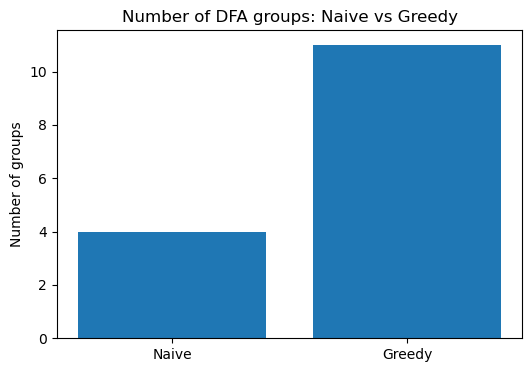

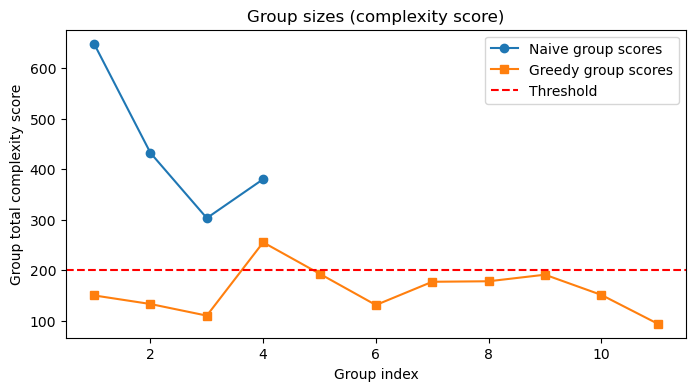

In [8]:
# grouping_experiment.py
import re
import math
import matplotlib.pyplot as plt

# Real-ish regex dataset (from earlier message)
patterns = [
    r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$",   # email
    r"https?://(www\.)?[a-zA-Z0-9-]+\.[a-z]{2,}",          # URL
    r"\b\d{1,3}(\.\d{1,3}){3}\b",                         # IPv4 address
    r"^[0-9]{16}$",                                       # Credit card number
    r"\+?[0-9]{1,4}?[-.\s]?\(?[0-9]{1,3}?\)?[-.\s]?[0-9]{3,}$", # Phone number
    r"(GET|POST) /[a-zA-Z0-9_/]* HTTP/1\.1",              # HTTP request line
    r"User-Agent:.*(curl|wget|nmap)",                     # Suspicious user agent
    r"(?:\d{1,3}\.){3}\d{1,3}",                           # Another IPv4
    r"([a-f0-9]{32})",                                    # MD5 hash
    r"(?:[0-9a-fA-F]{4}-){3}[0-9a-fA-F]{4}",              # License key pattern
    r"(passwd|shadow|group)",                             # Sensitive keywords
    r"([01]?\d|2[0-3]):[0-5]\d",                          # Time (HH:MM)
    r"[A-Fa-f0-9]{40}",                                   # SHA1 hash
    r"^\d{4}-\d{2}-\d{2}$",                               # Date (YYYY-MM-DD)
    r"[A-Z]{3}[0-9]{3}",                                  # Vehicle plate (example)
    r"(?:SELECT|UPDATE|DELETE|INSERT).*",                 # SQL injection keywords
    r"<script.*?>.*?</script>",                           # XSS attempt
    r"(\\x[0-9A-Fa-f]{2})+",                              # Hexadecimal bytes
    r"(?i)union\s+select",                                # SQLi keyword (case-insensitive)
    r"(?i)or\s+1=1",                                      # SQLi bypass
]

# ---------- Heuristic to estimate "DFA size" ----------
def regex_complexity_score(regex):
    """Estimate complexity / likely DFA size for a regex.
    This is a heuristic combining:
      - pattern length
      - count of repetition operators (* + ? { )
      - count of alternations (|)
      - count of groups ()
      - presence of wildcards (.)
    Returns an integer score ≥ 1.
    """
    length = len(regex)
    rep_ops = len(re.findall(r"(\*|\+|\?|\{)", regex))
    alternations = regex.count("|")
    groups = len(re.findall(r"\(", regex))
    wildcards = regex.count(".")
    char_classes = len(re.findall(r"\[.*?\]", regex))
    anchors = len(re.findall(r"(^|\$)", regex))  # not too important, but included

    # Weighted combination - tuneable
    score = (
        length * 1
        + rep_ops * 12
        + alternations * 20
        + groups * 8
        + wildcards * 10
        + char_classes * 8
        + anchors * 0
    )

    # Small floor to avoid zeros
    return max(1, int(score // 1))

# Quick look at scores
scores = [(p, regex_complexity_score(p)) for p in patterns]
for p, s in scores:
    print(f"score={s:3d}  | {p}")

# ---------- Grouping functions ----------
def naive_grouping(patterns, group_size=5):
    """Split patterns into fixed-size groups."""
    return [patterns[i:i+group_size] for i in range(0, len(patterns), group_size)]

def greedy_grouping(patterns, threshold=200):
    """Greedy pack patterns so each group's total score <= threshold."""
    groups = []
    current = []
    current_score = 0

    for p in patterns:
        s = regex_complexity_score(p)
        if current and current_score + s > threshold:
            groups.append((current, current_score))
            current = [p]
            current_score = s
        else:
            current.append(p)
            current_score += s
    if current:
        groups.append((current, current_score))
    return groups

# ---------- Run experiments ----------
group_size = 5
threshold = 200

naive = naive_grouping(patterns, group_size=group_size)
greedy = greedy_grouping(patterns, threshold=threshold)

print("\nNaive grouping (group size = {}):".format(group_size))
for i, g in enumerate(naive, 1):
    total = sum(regex_complexity_score(p) for p in g)
    print(f"  Group {i}: {len(g)} patterns, score={total}")

print("\nGreedy grouping (threshold = {}):".format(threshold))
for i, (g, total) in enumerate(greedy, 1):
    print(f"  Group {i}: {len(g)} patterns, score={total}")

# ---------- Simple comparison plot ----------
labels = ['Naive', 'Greedy']
counts = [len(naive), len(greedy)]

plt.figure(figsize=(6,4))
plt.bar(labels, counts)
plt.title("Number of DFA groups: Naive vs Greedy")
plt.ylabel("Number of groups")
plt.show()

# ---------- More detailed plot: group scores ----------
naive_scores = [sum(regex_complexity_score(p) for p in g) for g in naive]
greedy_scores = [total for (_, total) in greedy]

plt.figure(figsize=(8,4))
plt.plot(range(1, len(naive_scores)+1), naive_scores, marker='o', label='Naive group scores')
plt.plot(range(1, len(greedy_scores)+1), greedy_scores, marker='s', label='Greedy group scores')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Group index')
plt.ylabel('Group total complexity score')
plt.legend()
plt.title('Group sizes (complexity score)')
plt.show()
